In [1]:
import pandas as pd
import numpy as np
import eikon as ek
from statsmodels.regression.linear_model import OLS

In [2]:
def get_month_and_year_string(date: pd.Timestamp):
    month = date.month
    year = date.year
    return f'{year}-{month}'

def get_compounded_rate(r: pd.Series):
    r = 1+r
    r = r.prod()
    return r-1

In [3]:
path = r'C:\Users\serge\IdeaProjects\portfolio_manager\data\fama-french-factors'
path_apikeys = r'C:\Users\serge\OneDrive\Documents\apikeys.csv'
file = 'Developed_5_Factors_Daily.csv'

In [4]:
header_row = 2
index_row = 0
df_factors = pd.read_csv(filepath_or_buffer=fr'{path}\\{file}',
                           header=header_row,
                           index_col=index_row,
                           parse_dates=True, 
                           usecols=range(7))
#                            nrows=(end_row-8))

df_factors.replace({-99.99:np.nan}, inplace=True)
df_factors = df_factors / 100
df_factors.loc[:, 'date'] = df_factors.index
df_factors.set_index(np.arange(len(df_factors)), inplace=True)
df_factors

,Mkt-RF,SMB,HML,RMW,CMA,RF,date
0,0.0069,-0.0008,-0.0033,0.0021,0.0000,0.0003,1990-07-02
1,0.0018,0.0007,-0.0015,0.0005,0.0004,0.0003,1990-07-03
2,0.0062,-0.0018,-0.0017,-0.0004,0.0001,0.0003,1990-07-04
3,-0.0074,0.0031,0.0014,-0.0013,0.0004,0.0003,1990-07-05
4,0.0020,-0.0015,0.0002,0.0018,-0.0003,0.0003,1990-07-06
...,...,...,...,...,...,...,...
8560,0.0014,-0.0004,0.0021,0.0018,0.0029,0.0002,2023-04-24
8561,-0.0138,0.0000,0.0012,0.0015,0.0061,0.0002,2023-04-25
8562,-0.0038,0.0003,-0.0025,0.0014,-0.0002,0.0002,2023-04-26
8563,0.0123,-0.0062,-0.0044,0.0023,-0.0033,0.0002,2023-04-27


In [5]:
df_factors['period'] = df_factors['date'].apply(lambda x: get_month_and_year_string(x))

In [6]:
df_factors_monthly = df_factors.groupby('period').sum()[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
df_factors_monthly

,Mkt-RF,SMB,HML,RMW,CMA
period,,,,,
1990-10,0.0907,-0.0735,-0.0426,0.0278,0.0093
1990-11,-0.0366,0.0145,0.0110,0.0133,-0.0216
1990-12,0.0115,-0.0087,-0.0143,0.0136,-0.0029
1990-7,0.0079,0.0054,-0.0035,0.0018,0.0132
1990-8,-0.1100,-0.0178,0.0046,0.0020,0.0128
...,...,...,...,...,...
2022-9,-0.0971,-0.0164,0.0204,-0.0131,0.0120
2023-1,0.0675,0.0064,-0.0181,-0.0094,-0.0295
2023-2,-0.0266,0.0003,0.0064,-0.0009,0.0043


<AxesSubplot:xlabel='period'>

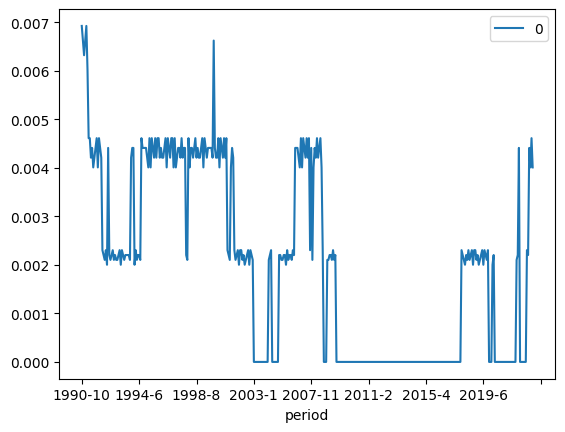

In [7]:
risk_free_monthly = df_factors.groupby('period').apply(lambda x: get_compounded_rate(x['RF']))
risk_free_monthly = risk_free_monthly.reset_index(level=0)
risk_free_monthly.drop_duplicates(subset=['period'], inplace=True)
risk_free_monthly.set_index('period', inplace=True)
risk_free_monthly
risk_free_monthly.plot()

In [8]:
df_factors = df_factors_monthly.join(risk_free_monthly, how='left')
df_factors

,Mkt-RF,SMB,HML,RMW,CMA,0
period,,,,,,
1990-10,0.0907,-0.0735,-0.0426,0.0278,0.0093,0.006923
1990-11,-0.0366,0.0145,0.0110,0.0133,-0.0216,0.006621
1990-12,0.0115,-0.0087,-0.0143,0.0136,-0.0029,0.006319
1990-7,0.0079,0.0054,-0.0035,0.0018,0.0132,0.006621
1990-8,-0.1100,-0.0178,0.0046,0.0020,0.0128,0.006923
...,...,...,...,...,...,...
2022-9,-0.0971,-0.0164,0.0204,-0.0131,0.0120,0.002202
2023-1,0.0675,0.0064,-0.0181,-0.0094,-0.0295,0.004409
2023-2,-0.0266,0.0003,0.0064,-0.0009,0.0043,0.004008


In [9]:
ek_api_key = pd.read_csv(path_apikeys, names=['api', 'key'], index_col=0)
ek.set_app_key(ek_api_key.loc['reuters'].values[0])

<AxesSubplot:xlabel='period'>

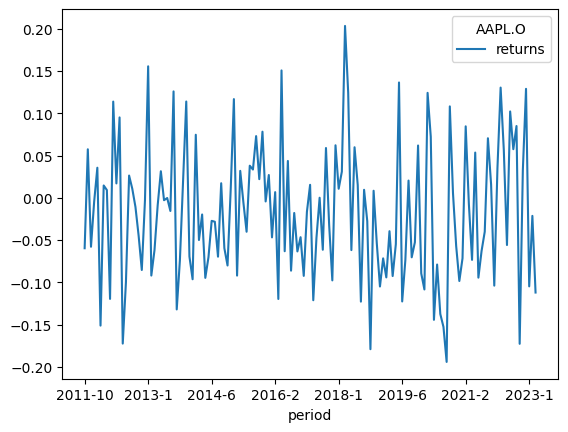

In [14]:
ric = 'AAPL.O'
df_prices = ek.get_timeseries(ric, start_date='1990-01-01', end_date='2023-04-01')
df_prices['date'] = df_prices.index
df_prices['returns'] = np.log(df_prices.CLOSE.shift(1) / df_prices.CLOSE)
df_prices['period'] = df_prices['date'].apply(lambda x: get_month_and_year_string(x))
df_returns = df_prices.groupby('period').sum()[['returns']]
df_returns.plot()

<AxesSubplot:xlabel='period'>

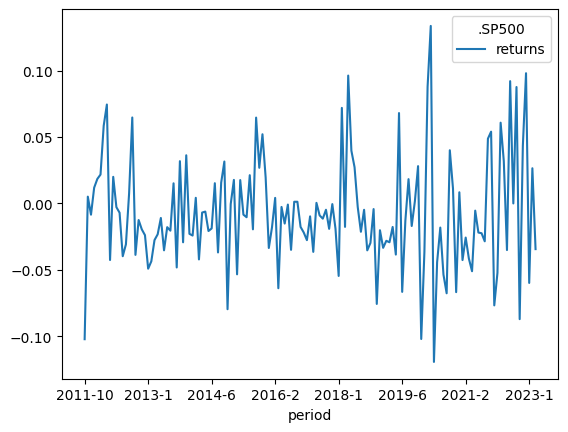

In [29]:
ric_market = '.SP500'
df_prices_market = ek.get_timeseries(ric_market, start_date='1990-01-01', end_date='2023-04-01')
df_prices_market['date'] = df_prices_market.index
df_prices_market['returns'] = np.log(df_prices_market.CLOSE.shift(1) / df_prices_market.CLOSE)
df_prices_market['period'] = df_prices_market['date'].apply(lambda x: get_month_and_year_string(x))
df_returns_market = df_prices_market.groupby('period').sum()[['returns']]
df_returns_market.plot()

In [30]:
df_returns_market

.SP500,returns
period,
2011-10,-0.102303
2011-11,0.005068
2011-12,-0.0085
2011-5,0.011842
2011-6,0.018425
...,...
2022-8,0.043366
2022-9,0.098048
2023-1,-0.059923


In [11]:
df = df_returns.join(df_factors, how='left')
df

,returns,Mkt-RF,SMB,HML,RMW,CMA,0
period,,,,,,,
2011-10,-0.059705,0.0988,-0.0223,-0.0171,-0.0044,-0.0090,0.000000
2011-11,0.0574,-0.0234,-0.0118,-0.0074,0.0145,0.0054,0.000000
2011-12,-0.057943,-0.0033,-0.0026,0.0184,0.0018,0.0141,0.000000
2011-5,-0.004466,-0.0205,-0.0045,-0.0131,0.0201,-0.0067,0.000000
2011-6,0.035585,-0.0142,-0.0017,0.0051,0.0183,-0.0038,0.000000
...,...,...,...,...,...,...,...
2022-8,0.033093,-0.0423,0.0054,0.0249,-0.0267,0.0130,0.002303
2022-9,0.128944,-0.0971,-0.0164,0.0204,-0.0131,0.0120,0.002202
2023-1,-0.104829,0.0675,0.0064,-0.0181,-0.0094,-0.0295,0.004409


In [15]:
model = OLS(endog=df.returns.astype(float),
            exog=df.iloc[:,1:-1].astype(float),
           hasconst=False)
res = model.fit()

In [16]:
res.params

Mkt-RF   -1.038396
SMB       0.668130
HML      -0.045412
RMW      -1.485384
CMA       0.975860
dtype: float64

In [17]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                returns   R-squared (uncentered):                   0.483
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                              25.77
Date:                Tue, 19 Sep 2023   Prob (F-statistic):                    2.65e-18
Time:                        23:13:49   Log-Likelihood:                          202.17
No. Observations:                 143   AIC:                                     -394.3
Df Residuals:                     138   BIC:                                     -379.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -1.0384      0.127     -8.188      0.000      -1.289      -0.788
SMB            0.6681      0.377      1.774      0.078      -0.076       1.413
HML           -0.0454      0.375     -0.121      0.904      -0.787       0.696
RMW           -1.4854      0.466     -3.185      0.002      -2.408      -0.563
CMA            0.9759      0.558      1.750      0.082      -0.127       2.078
==============================================================================
Omnibus:                       12.040   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.670
Skew:                           0.506   Prob(JB):                     0.000396
Kurtosis:                       4.267   Cond. No.                         5.86
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
ek.get_timeseries()

In [28]:
ek.get_data(instruments='US1MT=RR', fields=['TR.MIDPRICE', 'TR.MIDPRICE.calcdate'], SDate='1999-01-01', EDate='2023-04-01')

TypeError: get_data() got an unexpected keyword argument 'SDate'

In [ ]:
ek.get_data(instruments='.SP500', fields=['TR.MIDPRICE', 'TR.MIDPRICE.calcdate'], SDate='1999-01-01', EDate='2023-04-01')